# Scoring and Hand Strength Estimation

- **Scoring** refers to evaluating a fixed set of cards (e.g., a holding or a complete hand) based on poker hand rankings.
- **Strength estimation** refers to using Monte Carlo simulation to estimate the probability that a given holding will win a street involving multiple opponents.

In [1]:
# pip install scipy matplotlib

In [2]:
# imports for third-party libraries (you may need to install some of these via pip)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# imports from maverick
from maverick import Card, Deck, Holding, Hand, Suit, Rank
from maverick.utils import (
    estimate_holding_strength, 
    score_hand, 
    find_highest_scoring_hand
)

## Scoring

You can use scoring to tell which of two sets of cards is stronger at the moment.

You can evaluate the score of a Holding using the `score` method like this:

In [3]:
deck = Deck.build().shuffle()
holding = Holding(cards=deck.deal(2))
holding, holding.score()

(J♥ K♣, (<HandType.HIGH_CARD: 0>, 100.1311))

In [4]:
broadway = [
    Card(suit=Suit.HEARTS, rank=Rank.TEN),
    Card(suit=Suit.DIAMONDS, rank=Rank.JACK),
    Card(suit=Suit.CLUBS, rank=Rank.QUEEN),
    Card(suit=Suit.SPADES, rank=Rank.KING),
    Card(suit=Suit.HEARTS, rank=Rank.ACE),
]
holding = Holding(cards=broadway)
holding, holding.score()

(10♥ J♦ Q♣ K♠ A♥, (<HandType.STRAIGHT: 4>, 500.14))

You can also evaluate scores of hands:

In [5]:
deck = Deck.build().shuffle()
hand = Hand(private_cards=deck.deal(2), community_cards=deck.deal(3))
hand, hand.score()

(7♣ J♣ 3♠ 10♥ K♠, (<HandType.HIGH_CARD: 0>, 100.1311100703))

The hand can be partial:

In [6]:
deck = Deck.build().shuffle()
hand = Hand(private_cards=deck.deal(2), community_cards=deck.deal(1))
hand, hand.score()

(5♣ K♥ J♣, (<HandType.HIGH_CARD: 0>, 100.131105))

If you want more control, you can use the utility function directly. It is called `score_hands`, but you can give it any number of cards less then or equal to 5.

In [7]:
cards: list[Card] = deck.deal(1)
cards, score_hand(cards)

([Card(Jd)], (<HandType.HIGH_CARD: 0>, 100.11))

In [8]:
cards: list[Card] = deck.deal(3)
cards, score_hand(cards)

([Card(8c), Card(5d), Card(Qc)], (<HandType.HIGH_CARD: 0>, 100.120805))

In [9]:
cards: list[Card] = deck.deal(5)
cards, score_hand(cards)

([Card(8d), Card(9c), Card(4s), Card(2c), Card(Ad)],
 (<HandType.HIGH_CARD: 0>, 100.1409080402))

### Find the Highest Scoring Hand

Let's say you have two community cards and you are after the river. You want to know what is your best 5 cards at the moment, given your 2 private cards and the 4 community cards. You can answer this with the `find_strongest_hand` utility function.

In [10]:
deck = Deck.build().shuffle()
private_cards: list[Card] = deck.deal(2)
community_cards: list[Card] = deck.deal(4)
hand, hand_type, hand_score = find_highest_scoring_hand(
    private_cards, community_cards
)

print("Private Cards:", private_cards)
print("Community Cards:", community_cards)
print("Highest scoring hand:", hand)
print("Highest scoring hand type:", hand_type.name)
print("Highest scoring hand score:", hand_score)

Private Cards: [Card(3d), Card(6d)]
Community Cards: [Card(2s), Card(Qc), Card(5h), Card(7c)]
Highest scoring hand: [Card(3d), Card(6d), Card(Qc), Card(5h), Card(7c)]
Highest scoring hand type: HIGH_CARD
Highest scoring hand score: 100.1207060503


Of course, the score of a set of cards is not meaningful by itself. It simply provides a way to compare two sets of cards to determine which is currently stronger. If you want a more informative measure of a set of cards' strength, you should use strength estimation.

## Holding Strength Estimation

For estimating the stregth of a set of cards, we use a Monte-Carlo simulation. What it returns is the probability of winning a street against a number of opponents.

Here is an example for estimating the strength of a pair of aces:

In [11]:
pair_of_aces = Holding(cards=[
    Card(suit=Suit.SPADES, rank=Rank.ACE),
    Card(suit=Suit.HEARTS, rank=Rank.ACE)
])
prob = pair_of_aces.estimate_strength(n_simulations=1000, n_players=8)
print(f"Estimated strength of {pair_of_aces.cards} is {prob:.2%}\n")

Estimated strength of [Card(As), Card(Ah)] is 39.50%



In [14]:
pair_of_aces = Holding(cards=[
    Card(suit=Suit.SPADES, rank=Rank.ACE),
    Card(suit=Suit.HEARTS, rank=Rank.ACE)
])
comunity_cards = [
    Card(suit=Suit.CLUBS, rank=Rank.ACE),
]
prob = pair_of_aces.estimate_strength(
    n_simulations=1000, 
    n_players=8, 
    community_cards=comunity_cards,
    n_community_cards_total = 5,
)
print(f"Estimated strength of {pair_of_aces.cards} is {prob:.2%}\n")

Estimated strength of [Card(As), Card(Ah)] is 76.90%



If you are playing Omaha, you must use exactly 2 cards from your hand.

In [ ]:
private_cards = Holding(cards=[
    Card(suit=Suit.SPADES, rank=Rank.ACE),
    Card(suit=Suit.HEARTS, rank=Rank.ACE),
    Card(suit=Suit.CLUBS, rank=Rank.TWO),
    Card(suit=Suit.HEARTS, rank=Rank.FIVE)
])
comunity_cards = [
    Card(suit=Suit.CLUBS, rank=Rank.ACE),
]
prob = private_cards.estimate_strength(
    n_simulations=1000, 
    n_players=8,
    community_cards=comunity_cards,
    n_community_cards_total=5,
    n_private=2,  # specify that 2 private cards must be used
)
print(f"Estimated strength of {private_cards.cards} is {prob:.2%}\n")

Estimated strength of [Card(As), Card(Ah), Card(2c), Card(5h)] is 54.70%



If you need more control, you can use the utility function directly:

In [38]:
cards = Deck.build().shuffle().deal(2)
prob = estimate_holding_strength(cards, n_simulations=1000, n_players=8)
print(f"Estimated strength of {cards} is {prob:.2%}\n")

Estimated strength of [Card(5h), Card(8s)] is 9.90%



Running the same simulation a number of times would likely yield different probabilities. To get a more accurate estimation, we can visualize the distribution of probabilities for a pair of aces using a histogram.

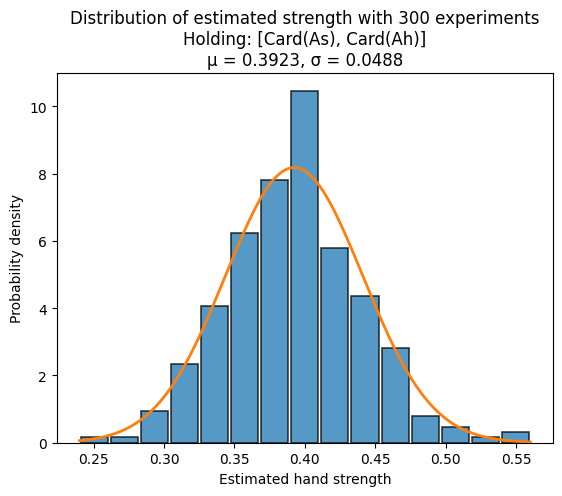

In [16]:
# Hyperparameters
n_experiment = 300
n_simulations = 100
n_players = 8
experiments = []

pair_of_aces = Holding(cards=[
    Card(suit=Suit.SPADES, rank=Rank.ACE),
    Card(suit=Suit.HEARTS, rank=Rank.ACE)
])

# Run experiments
for i in range(n_experiment):
    strength = pair_of_aces.estimate_strength(
        n_simulations=n_simulations,
        n_players=n_players
    )
    experiments.append(strength)

# Convert to numpy array
experiments = np.asarray(experiments)

# Fit Gaussian parameters
mu = experiments.mean()
sigma = experiments.std(ddof=1)

# Histogram as density
plt.hist(
    experiments,
    bins=15,
    density=True,
    rwidth=0.9,
    edgecolor="black",
    linewidth=1.2,
    alpha=0.75
)

# NOTE: The parameter ``density=True`` is crucial as it normalizes the histogram.
# Without this, the empirical histogram and the Gaussian PDF would be on different scales.

# Gaussian PDF
x = np.linspace(experiments.min(), experiments.max(), 500)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, linewidth=2)

# Formatting
plt.xlabel("Estimated hand strength")
plt.ylabel("Probability density")
plt.title((
    f"Distribution of estimated strength with {n_experiment} experiments\n"
    f"Holding: {pair_of_aces.cards}\n"
    f"\u03BC = {mu:.4f}, \u03C3 = {sigma:.4f}"
))

# Show plot
plt.show()